In [1]:
import numpy as np
import json
import scipy.spatial as ssp
import scipy.interpolate as ssi
import matplotlib.pyplot as plt
import cv2
import skimage as ski
import imageio

In [222]:
face1 = "bill_murray"
face2 = "evan_closedmouth"

In [223]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(f"faces/{path}.jpg"), cv2.COLOR_BGR2RGB)

In [224]:
im1 = load_image(face1)
im2 = load_image(face2)

In [275]:
with open("correspondences/" + face1 + "_" + face2 + ".json") as f:
    corr = json.load(f)

# Add to the points the corners of the image
corners = [[0, 0], [0, im1.shape[0]-1], [im1.shape[1]-1, 0], [im1.shape[1] - 1, im1.shape[0] - 1]]
corr["im1Points"].extend(corners)
corr["im2Points"].extend(corners)

# Add midpoints to each edge of the image
# edges = [[0, im1.shape[0]//2], [im1.shape[1]//2, 0], [im1.shape[1] - 1, im1.shape[0]//2], [im1.shape[1]//2, im1.shape[0] - 1]]
# corr["im1Points"].extend(edges)
# corr["im2Points"].extend(edges)

pts1 = np.array(corr["im1Points"])
pts2 = np.array(corr["im2Points"])

In [276]:
triangulation = ssp.Delaunay(pts1)

bill_murray Triangulation


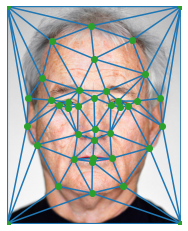

evan_closedmouth Triangulation


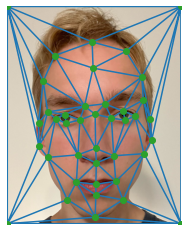

In [277]:
def visualize_points(pts, tri, im):
    plt.triplot(pts[:, 0], pts[:, 1], tri.simplices)
    plt.plot(pts[:, 0], pts[:, 1], 'o')
    plt.gca().set_aspect("equal")
    plt.imshow(im)
    plt.axis("off")
    plt.show()
print(f"{face1} Triangulation")
visualize_points(pts1, triangulation, im1)
print(f"{face2} Triangulation")
visualize_points(pts2, triangulation, im2)

In [278]:
def midpoints(pts1, pts2, warp_frac=0.5):
    # Computes a set of points that is halfway between pts1 and pts2
    return pts1 + (pts2 - pts1)*warp_frac

In [279]:
def computeAffine(tri1_pts, tri2_pts):
    tr1pe = np.concatenate([tri1_pts, np.ones((3, 1))], axis=1).T
    tr2pe = np.concatenate([tri2_pts, np.ones((3, 1))], axis=1).T
    return np.linalg.solve(tr1pe.T, tr2pe.T).T

In [280]:
mdpts = midpoints(pts1, pts2)
tri1 = pts1[triangulation.simplices]
tri2 = pts2[triangulation.simplices]
mdtri = mdpts[triangulation.simplices]

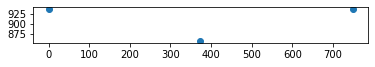

In [281]:
plt.scatter(mdtri[2:3,:, 0], mdtri[2:3,:, 1])
plt.gca().set_aspect("equal")

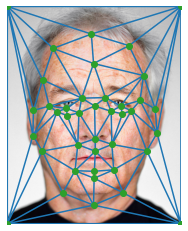

In [282]:
visualize_points(mdpts, triangulation, im1)

In [283]:
def mid_img_helper(mdtri, tri, im, mid_img, dissolve_frac):
    interp = ssi.RegularGridInterpolator((np.arange(im.shape[0]), np.arange(im.shape[1])), im, bounds_error=False, fill_value=255) # An interpolator
    for i in range(mdtri.shape[0]): # Loop through each triangle
        A = computeAffine(tri[i], mdtri[i])
        
        rr_mid, cc_mid = ski.draw.polygon(mdtri[i, :, 0], mdtri[i, :, 1])

        # The points of the triangle in the mid image
        dest = np.vstack([rr_mid, cc_mid, np.ones(rr_mid.shape[0])]).astype(int)
        # The points of the triangle in the mid image inversed to be in the original
        backward_pts = (np.linalg.inv(A) @ dest).T[:, :2]
        # Now, set the pixel values of this triangle in the destination image
        dest = dest[:2]
        mid_img[dest[1], dest[0]] += interp(np.flip(backward_pts, axis=1))*dissolve_frac

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


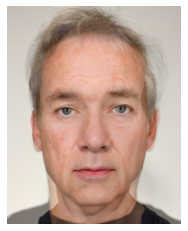

In [285]:
mid_img = np.zeros(im1.shape)
mid_img_helper(mdtri, tri1, im1, mid_img, dissolve_frac=0.5)
mid_img_helper(mdtri, tri2, im2, mid_img, dissolve_frac=0.5)
plt.axis("off")
plt.imshow(mid_img.astype(int))

In [235]:
def morph(im1, im2, im1_pts, im2_pts, triangulation, warp_frac, dissolve_frac):
    mdpts = midpoints(im1_pts, im2_pts, warp_frac=warp_frac)
    
    if warp_frac == 0 and dissolve_frac == 0:
        return im1
    elif warp_frac == 1 and dissolve_frac == 1:
        return im2

    tri1 = im1_pts[triangulation.simplices]
    tri2 = im2_pts[triangulation.simplices]
    mdtri = mdpts[triangulation.simplices]
    
    mid_img = np.zeros(im1.shape)
    mid_img_helper(mdtri, tri1, im1, mid_img, dissolve_frac=1 - dissolve_frac)
    mid_img_helper(mdtri, tri2, im2, mid_img, dissolve_frac=dissolve_frac)
    
    return np.clip(mid_img, 0, 255)

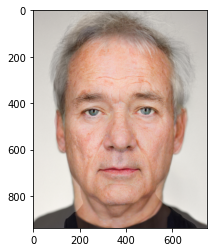

In [236]:
plt.imshow(morph(im1, im2, pts1, pts2, triangulation, 0.3, 0.3).astype(int))

In [237]:
# frames = []
# num_frames = 45
# for frac in np.linspace(0, 1, num_frames):
#     frames.append(morph(im1, im2, pts1, pts2, triangulation, frac, frac))

In [238]:
# imageio.mimsave(f'gifs/{face1}_{face2}.gif', np.array(frames).astype(np.uint8), duration=num_frames/30)

In [290]:
# Now load in the faces for computing the average face
ims = []
corrs = []
for i in range(1, 201):
    ims.append(load_image(f"frontalimages_spatiallynormalized/{i}a"))
    with open(f"correspondences/frontalshapes_manuallyannotated_46points/{i}a.pts") as f:
        # Skip the first three lines
        f.readline()
        f.readline()
        f.readline()      
        
        # Read the next 46 lines
        corrs.append([])
        for _ in range(46):
            line = f.readline()
            corrs[-1].append([float(num) for num in line[:-1].split()])
        corners = [[0, 0], [0, ims[-1].shape[0]-1], [ims[-1].shape[1]-1, 0], [ims[-1].shape[1] - 1, ims[-1].shape[0] - 1]]
        corrs[-1].extend(corners)
corrs = np.array(corrs)
ims = np.array(ims)

In [291]:
ims.shape

(200, 300, 250, 3)

In [292]:
mdpts = np.sum(corrs, axis=0)/corrs.shape[0]
triangulation = ssp.Delaunay(mdpts)
mdtri = mdpts[triangulation.simplices]
mdpts = np.sum(corrs, axis=0)/corrs.shape[0]

In [293]:
mid_img = np.zeros(ims.shape[1:])
for i in range(len(ims)):
    im = ims[i]
    pts = corrs[i]
    tri = pts[triangulation.simplices]
    mid_img_helper(mdtri, tri, im, mid_img, 1/corrs.shape[0])

In [294]:
def get_average(corrs, ims):
    mdpts = np.sum(corrs, axis=0)/corrs.shape[0]
    triangulation = ssp.Delaunay(mdpts)
    mdtri = mdpts[triangulation.simplices]

    mid_img = np.zeros(ims.shape[1:])
    for i in range(len(ims)):
        im = ims[i]
        pts = corrs[i]
        tri = pts[triangulation.simplices]
        mid_img_helper(mdtri, tri, im, mid_img, 1/corrs.shape[0])
    return mid_img, mdpts, triangulation

In [295]:
average_face, mdpts, triangulation = get_average(corrs, ims)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Average Face


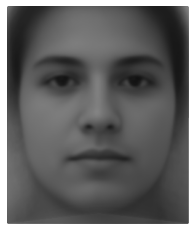

In [296]:
print("Average Face")
plt.axis("off")
plt.imshow(average_face.astype(int))

In [297]:
# Compute a set of gifs of morphing into the average face
all_frames = []
for i in np.arange(0, corrs.shape[0], 50):
    im1 = ims[i]
    pts1 = corrs[i]
    frames = []
    num_frames = 45
    for frac in np.linspace(0, 1, num_frames):
        frames.append(morph(im1, average_face, pts1, mdpts, triangulation, frac, 0))
    all_frames.append(frames)
    imageio.mimsave(f'gifs/{i}a_average.gif', np.array(frames).astype(np.uint8), duration=num_frames/30)

In [247]:
# # Code to view the ordering of points on the sample images
# a = 38
# b = 50
# plt.scatter(corrs[2, a:b, 0], corrs[2, a:b, 1])

# for i, txt in enumerate(list(np.arange(a, b))):
#     plt.annotate(txt, (corrs[2, a + i, 0], corrs[2, a + i, 1]), color="white")
    
# plt.imshow(ims[2])
# plt.show()

In [298]:
evan_im = load_image("evan_closedmouth_250_300")
with open("correspondences/evan_closedmouth_250_300_evan_closedmouth_250_300.json") as f:
    evan_corr = json.load(f)["im1Points"]
corners = [[0, 0], [0, evan_im.shape[0]-1], [evan_im.shape[1]-1, 0], [evan_im.shape[1] - 1, evan_im.shape[0] - 1]]
evan_corr.extend(corners)
evan_corr = np.array(evan_corr)

In [299]:
# Morph Evan into the average face
frames = []
num_frames = 45
for frac in np.linspace(0, 1, num_frames):
    frames.append(morph(evan_im, average_face, evan_corr, mdpts, triangulation, frac, 0))

imageio.mimsave(f'gifs/evan_average.gif', np.array(frames).astype(np.uint8), duration=num_frames/30)

In [303]:
# Morph the average face into Evan
frames = []
num_frames = 45
for frac in np.linspace(0, 1, num_frames):
    frames.append(morph(average_face, evan_im, mdpts, evan_corr, triangulation, frac, 0))

imageio.mimsave(f'gifs/average_evan.gif', np.array(frames).astype(np.uint8), duration=num_frames/30)

In [251]:
female_indices = np.array([11, 12, 15, 21, 25, 26, 28, 29, 37, 39, 43, 51, 58, 60, 62, 69, 72, 75, 78, 79, 84, 85, 86, 87, 91, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 117, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 189, 195, 196, 197, 198, 199, 200]) - 1
female_corrs = corrs[female_indices]
female_ims = ims[female_indices]

In [252]:
female_average_face, female_mdpts, female_triangulation = get_average(female_corrs, female_ims)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


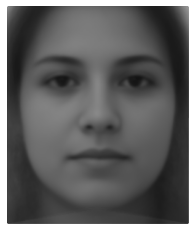

In [287]:
plt.axis("off")
plt.imshow(female_average_face.astype(int))

In [254]:
male_indices = np.setdiff1d(np.arange(200), female_indices)
male_corrs = corrs[male_indices]
male_ims = ims[male_indices]

In [255]:
male_average_face, male_mdpts, male_triangulation = get_average(male_corrs, male_ims)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


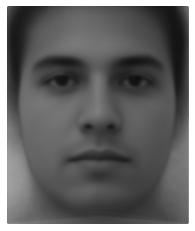

In [288]:
plt.axis("off")
plt.imshow(male_average_face.astype(int))

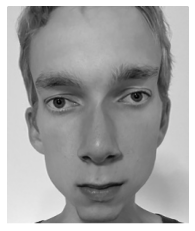

In [304]:
# Caricature!
frac = 1.5
plt.axis("off")
plt.imshow(morph(male_average_face, evan_im, male_mdpts, evan_corr, male_triangulation, frac, 1).astype(int))

Create a video of me from young to now

In [258]:
# ttys = through the years
ttys_ims = [load_image(f"ttys/{i}") for i in range(4)]
ttys_corrs = []
with open("correspondences/ttys/0_1.json") as f:
    _corrs = json.load(f)
    ttys_corrs.append(_corrs["im1Points"])
    ttys_corrs.append(_corrs["im2Points"])   

with open("correspondences/ttys/2_3.json") as f:
    _corrs = json.load(f)
    ttys_corrs.append(_corrs["im1Points"])
    ttys_corrs.append(_corrs["im2Points"])
corners = [[0, 0], [0, ttys_ims[0].shape[0] - 1], [ttys_ims[0].shape[1] - 1, 0], [ttys_ims[0].shape[1] - 1, ttys_ims[0].shape[0] - 1]]

for i in range(len(ttys_corrs)):
    ttys_corrs[i].extend(corners)

ttys_ims = np.array(ttys_ims)
ttys_corrs = np.array(ttys_corrs)

In [259]:
ttys_tri = ssp.Delaunay(ttys_corrs[0])
ttys_frames = []
for i in range(len(ttys_corrs) - 1):
    num_frames = 45
    ttys_frames.append([])
    for frac in np.linspace(0, 1, num_frames):
        ttys_frames[-1].append(morph(ttys_ims[i], ttys_ims[i+1], ttys_corrs[i], ttys_corrs[i+1], ttys_tri, frac, frac))

ttys_frames = np.array(ttys_frames)
ttys_frames = ttys_frames.reshape(-1, *ttys_frames.shape[2:])

In [260]:
imageio.mimsave(f'gifs/ttys.gif', ttys_frames.astype(np.uint8), duration=ttys_frames.shape[0]/30)

Female Caricature

In [305]:
evan_im = load_image("evan_closedmouth_400_623")
female_im = load_image("white_female_average")

with open("correspondences/evan_closedmouth_400_623_white_female_average.json") as f:
    _corrs = json.load(f)
    evan_corrs = _corrs["im1Points"]
    female_corrs = _corrs["im2Points"]
corners = [[0, 0], [0, evan_im.shape[0] - 1], [evan_im.shape[1] - 1, 0], [evan_im.shape[1] - 1, evan_im.shape[0] - 1]]

evan_corrs.extend(corners)
female_corrs.extend(corners)

evan_corrs = np.array(evan_corrs)
female_corrs = np.array(female_corrs)

In [306]:
female_triangulation = ssp.Delaunay(female_corrs)

Morphing just shape


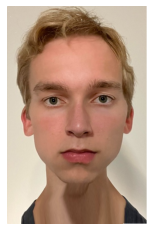

In [310]:
print("Morphing just shape")
plt.axis("off")
plt.imshow(morph(female_im, evan_im, female_corrs, evan_corrs, female_triangulation, 0.4, 1).astype(int))

Morphing just appearance


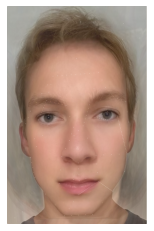

In [311]:
print("Morphing just appearance")
plt.axis("off")
plt.imshow(morph(female_im, evan_im, female_corrs, evan_corrs, female_triangulation, 1, 0.4).astype(int))

Morphing both


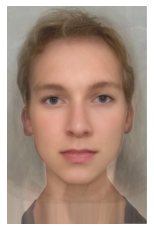

In [312]:
print("Morphing both")
plt.axis("off")
plt.imshow(morph(female_im, evan_im, female_corrs, evan_corrs, female_triangulation, 0.4, 0.4).astype(int))